# 군집화 실습

- 고객 세분화 기법
    - 고객 세그먼테이션
    - 다양한 기준으로 고객을 분류하는 기법
    - CRM, 마케팅에 중요 요소

In [1]:
from IPython.display import Image

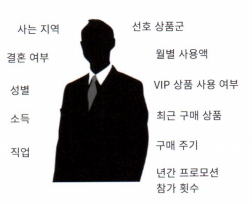

In [2]:
Image('./res/머신러닝_알고리즘_참고쟈료/cluster_cus_1.png')
# 고객 세분화 전략의  주요 목표는 타겟 마케팅이다
# 고객의 어떤 정보를 이용하여 군집화 할것이다 -> RFM 기법을 사용
# R : Recency : 가장 최근 상품 구입일로부터  오늘까지 경과된 기간(분석기준일)
# F : Frequency : 상품 구매 회수(컨텐츠 이용 회수)
# M : Monetary Value : 총 구매 금액(쇼핑몰 기준)

## 연구 목표
- 고객 세분화
    - RFM 기법을 이용하여 고객을 군집화 한다.

### 데이터 확보
- http://archive.ics.uci.edu/ml/datasets/online+retail 획득
- Online Retail.xlsx

In [3]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# 데이터 로드
retail_df = pd.read_excel('./res/Online Retail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [41]:
'''
'InvoiceNo'   : 주문번호, c로 시작하면 취소주문
'StockCode'   : 제품코드
'Description' : 제품 설명
'Quantity'    : 주문시 제품의 개수
'InvoiceDate' : 주문일자
'UnitPrice'   : 제품 단가
'CustomerID'  : 고객 번호 
'Country'     : 고객의 국적
------------------------------
'''
# R : Recency : 가장 최근 상품 구입일로부터  오늘까지 경과된 기간(분석기준일)
# F : Frequency : 상품 구매 회수(컨텐츠 이용 회수)
# M : Monetary Value : 총 구매 금액(쇼핑몰 기준)
'''
대상 고객을 정의 -> 결측 제거!!, 특정국가에 집중되어있어서,편차가 너무 크면 특정 국가로 한정검토
R : 고객의 InvoiceDate 기준으로 정렬->현재날짜로부터 가장최근에구매한날짜까지 경과한 day(일수)
F : 주문의 총개수(횟수)
M : (UnitPrice(단가) * Quantity(개수)) 주문별 총합
'''
retail_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'amount'],
      dtype='object')

### 대상 특정

In [42]:
#전체 데이터에 대한 통찰
# 결측 여부, 확인 -> 컬럼별로 확인하고 싶다, 데이터에 대한 정보를 보고싶다.
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  int32         
 7   Country      354321 non-null  object        
 8   amount       354321 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 25.7+ MB


In [43]:
# info()을 통해서 일부 결측치가 확인되었다. => 대상을 특정
retail_df.shape

(354321, 9)

### 데이터 준비
- 1. 대상이 되는 데이터를 추출
- 2. RFM에 맞게 끔 컬럼을 구성한다.
- 3. 군집화 구현

#### 대상이 되는 데이터를 추출

In [44]:
# 대상이 되는 데이터를 추출 -> 데이터 정제
retail_df = retail_df[retail_df['Quantity'] > 0] # 주문 수량이 0개 이상
retail_df = retail_df[retail_df['UnitPrice'] > 0] # 제품 단가가 0 이상
retail_df = retail_df[retail_df['CustomerID'].notnull() ] # 데이터가 존재하는 것만 남긴다
retail_df.shape
# 데이터가 대략 16만개 정도 정제되었다.

(354321, 9)

In [45]:
# 컬럼별로 확인 -> 모든 컬럼에서 결측 제거됨
retail_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
amount         0
dtype: int64

In [46]:
# 고객 국적 검토
retail_df['Country'].value_counts()[:10]
# United Kingdom (영국) 의 고객 비율이 압도적이다 ->
# 영국 고객만 대상으로 처리하겠다. (설정)

United Kingdom    354321
Name: Country, dtype: int64

In [47]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
retail_df.shape
# 354321개 데이터

(354321, 9)

#### RFM에 맞게끔 컬럼을 구성한다.

In [48]:
"""
'InvoiceNo' : 주문번호, c로 시작하면 취소주문
'StockCode'   : 제품코드
'Description' : 제품 설명
'Quantity'    : 주문시 제품의 개수
'InvoiceDate' : 주문일자
'UnitPrice'   : 제품 단가
'CustomerID'  : 고객 번호 
'Country'     : 고객의 국적 
"""

# amount = 제품 수량 * 제품 단가 => 주문 1개에 대한 구매비용
retail_df['amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
# 고객아이디는 정수 수치로 저장
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [49]:
retail_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [50]:
# 고객별로 총 구매금액을 합산해서 정렬해서 상위 10개 출력
retail_df.groupby('CustomerID')['amount'].sum().sort_values(ascending=False)[:10]
# 상위 3명의 아이디가 주문총액의 비중이 크다 => 몇몇 고객이 큰 주문 금액을 가지고 있다.
# 이 데이터에는 단체 주문이 있었다. => 3명의 고객이 주문금액이 큰 이유!!

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
12346     77183.60
16684     66653.56
14096     65164.79
13694     65039.62
15311     60767.90
Name: amount, dtype: float64

In [51]:
retail_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'amount'],
      dtype='object')

In [52]:
# RFM에 해당되는 컬럼 준비
operation = {
    # 대상컬럼 : 처리함수
    'InvoiceDate' : 'max', # R
    'InvoiceNo' : 'count', # F : c로 시작하는 취소주문은 배제
    'amount' : 'sum'       # M  
}
cus_df = retail_df.groupby('CustomerID').agg(operation)
cus_df.head(2)

,InvoiceDate,InvoiceNo,amount
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01


In [53]:
# 컬럼명을 정확하게 대체
# R : Recency : 가장 최근 상품 구입일로 부터 오늘까지 경과된 기간(분석기준일)
# F : Frequency : 상품 구매 횟수 (컨텐츠 이용횟수)
# M : Monetary Value : 총 구매 금액(쇼핑몰 기준)
cus_df.columns = ['Recency','Frequency','Monetary']
cus_df.head(2)

,Recency,Frequency,Monetary
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01


In [54]:
# CustomerID를 컬럼으로 이동시킨다.
cus_df.reset_index(inplace=True)
cus_df.head(2)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01


In [55]:
# 오늘은 현 데이터 기준 마지막 데이터 다음날이다. 
# Recency는 고객별 마지막 구매일로부터 지금 분석을 하는 날까지 경과 day(일)
import datetime as dt
# 이 데이터를 분석하는 날짜 -> 10/12/2011
tmp = dt.datetime(2011, 12, 10) - cus_df['Recency']
# 가장 최근 구매일 경우에는 24시간이 지나지 않아서, 0day가 된다. 보정하던지, 무시 <- 결정
type(tmp)

pandas.core.series.Series

In [56]:
cus_df['Recency'] = tmp.apply(lambda x:x.days+1)
cus_df.head(2)

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01


In [57]:
cus_df.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary'], dtype='object')

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

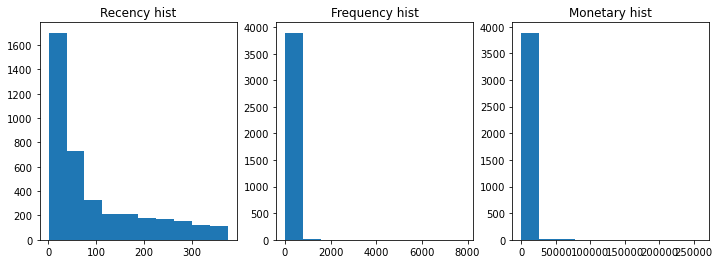

In [58]:
# 일부 소매업체에서 대규모로 주문을 한 내역이 존재한다(사전 제공 정보)
# 고객 세분화 작업을 하는데 있어서, 매우 왜곡된 데이터 분포를 가질수 있다.
# 한쪽 군집으로 쏠릴 수 (집중될 수) 있다
# 확인 => 히스토그램
chart_num = 3 # 3개의 속성에 대해 히스토그램 플로팅
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(4*chart_num, 4), nrows=1, ncols=chart_num)

ax1.set_title('Recency hist')
ax2.set_title('Frequency hist')
ax3.set_title('Monetary hist')

ax1.hist(cus_df['Recency'])
ax2.hist(cus_df['Frequency'])
ax3.hist(cus_df['Monetary'])

# Frequency, Monetary 는 값 간의 편차가 너무 크고, 왜곡된 분포도를 보인다.

In [59]:
# 통계 요약 : Recency, Frequency, Monetary 컬럼만 확인
cus_df.describe()
# 표준편차가 너무 크다. 최댓값 대비, 평균의 차이도 많이 난다.
# 몇개의 값이 전체를 왜곡하고 있다.
# 군집화를 수행해도 변별력이 떨어진다.
# 해결방안 -> 로그 혹은 제거

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,92.742092,90.388010,1864.385601
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,1.000000,1.000000,3.750000
25%,14208.750000,18.000000,17.000000,300.280000
50%,15569.500000,51.000000,41.000000,652.280000
75%,16913.250000,143.000000,99.250000,1576.585000
max,18287.000000,374.000000,7847.000000,259657.300000


#### 절차
- 현 데이터로 군집화 후 평가를 수행
- 로그 처리 후 다시 군집화 후 평가를 수행

In [60]:
# 모듈 가져오기
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

In [61]:
# Recency, Frequency, Monetary 등 3개의 컬럼에 대해서 값만 추출
X_features = cus_df[['Recency','Frequency','Monetary']].values
X_features

array([[3.260000e+02, 1.000000e+00, 7.718360e+04],
       [3.000000e+00, 1.030000e+02, 4.196010e+03],
       [1.000000e+00, 4.595000e+03, 3.371973e+04],
       ...,
       [8.000000e+00, 1.200000e+01, 1.780500e+02],
       [4.000000e+00, 7.560000e+02, 2.094880e+03],
       [4.300000e+01, 7.000000e+01, 1.837280e+03]])

In [62]:
# StandardScaler로 전처리해서
X_features_scaled = StandardScaler().fit_transform(X_features)
X_features_scaled

array([[ 2.34381090e+00, -4.10449826e-01,  1.00669064e+01],
       [-9.01742172e-01,  5.79114471e-02,  3.11636875e-01],
       [-9.21838476e-01,  2.06841746e+01,  4.25767546e+00],
       ...,
       [-8.51501413e-01, -3.59940277e-01, -2.25389800e-01],
       [-8.91694020e-01,  3.05634195e+00,  3.08070865e-02],
       [-4.99816095e-01, -9.36172002e-02, -3.62284108e-03]])

In [63]:
# 군집 3개로, 난수 시드는 0으로 KMeans로 군집화 하시오
# cus_df에 군집된 결과를 cluster_label에 담으시오 (컬럼추가)
kmeans = KMeans(n_clusters=3, random_state=0)
cus_df['cluster_label'] = kmeans.fit_predict(X_features_scaled)
cus_df.head(2)

,CustomerID,Recency,Frequency,Monetary,cluster_label
0,12346,326,1,77183.60,2
1,12747,3,103,4196.01,0


In [64]:
# 실루엣 스코어 -> 평균값 출력
# 1에 가까우면 군집이 잘되었다.
# 0에 가까우면 군집이 잘 안되었다.
# -1에 가까우면 -> 다시(데이터부터)!! 군집이 겹쳤다.
silhouette_score(X_features_scaled, cus_df['cluster_label'])

0.5924537813510861

In [65]:
import matplotlib.cm as cm

In [69]:
def visual_silhouette_check(candidate_clusters, features) :
    ncols = len(candidate_clusters)
    _,axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*5,5))
    
    for idx, size in enumerate(candidate_clusters) :
        cluster_model = KMeans(n_clusters=size, max_iter=500, random_state=0)
        cluster_label = cluster_model.fit_predict(features)
        sil_values = silhouette_samples(features, cluster_label)
        sil_avg = silhouette_score(features, cluster_label)
        
        y_st_lower = 10
        for i in range(size) :
            tmp = sil_values[cluster_label == i]
            tmp.sort()
            y = np.arange(y_st_lower, y_st_lower+tmp.shape[0])
            x1 = 0 
            x2 = tmp
            color = cm.nipy_spectral(i/size)
            axes[idx].fill_betweenx(y,x1, x2, alpha=0.7, edgecolor=color, facecolor=color)
            
            axes[idx].text(-0.03, y_st_lower + tmp.shape[0]/2, str(i))
            y_st_lower = y_st_lower + tmp.shape[0] + 10
            
        axes[ idx ].set_title(f'cluster counts {size}, sil_avg={round(sil_avg,3)}')
        axes[ idx ].set_xlabel( 'silhoette score' )
        axes[ idx ].set_ylabel( 'cluster label' )
        axes[ idx ].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        axes[ idx ].set_yticks([])          

        axes[ idx ].axvline(x=sil_avg, color='red',linestyle='--')

In [70]:
# 군집 갯수가 변화됨에 따라 산포도를 각각 그리는 함수
# cluster_lists : 군집화 하고 싶은 갯수의 후보 리스트
# X_features    :군집화를 수행하는 원본 데이터
def visual_cluster_scatter(cluster_lists, X_features) :
    # 1. 차트모양 잡기
    chart_num = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*chart_num, 4), nrows=1, ncols=chart_num)
    # 2. PCA 압축을 이용하여 2개로 데이터를 생성한다. 이것을 이용하여 군집
    pca = PCA(n_components=2, random_state=0)
    tmp = pca.fit_transform(X_features)
    df  = pd.DataFrame(tmp, columns=['pca_1','pca_2'])
    # 3. 군집 갯수별로 KMeans 군집 -> 시각화(산포도)
    markers = ['o','s','^','x','*','+']
    for idx, cluster_num in enumerate(cluster_lists) :
        # 3-1. 클러스터링 수행
        kmeans = KMeans(n_clusters=cluster_num, max_iter=500, random_state=0)
        df['cluster'] = kmeans.fit_predict(df.values)
        # 3-2. 군집의 갯수 : len(df['cluster'].unique) == cluster_num 같다
        labels = np.unique(kmeans.labels_) # 군집을 종류별로 구해서
        print(labels)
        # 3-3. 군집별로 분포도를 그린다.
        for label in labels :
            # 3-3-1. 대상 데이터만 추출
            labeled_df = df[df['cluster'] == label]
            # 3-3-2. 시각화
            axs[idx].scatter(x=labeled_df['pca_1'], y=labeled_df['pca_2'],
                            s=70,
                            edgecolor='k',
                            marker=markers[label],
                            label=f'cluster-{label}')
            axs[idx].legend()
            axs[idx].set_title(f'Cluster counts {cluster_num}')
    
    plt.show()

[0 1]
[0 1 2]
[0 1 2 3]
[0 1 2 3 4]


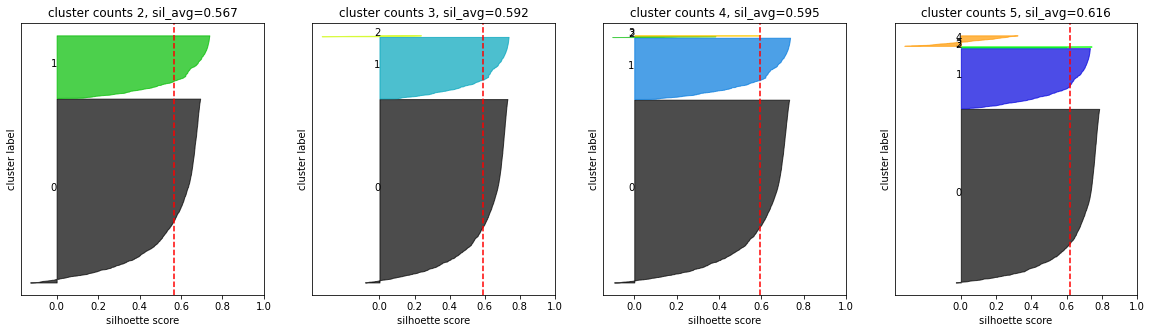

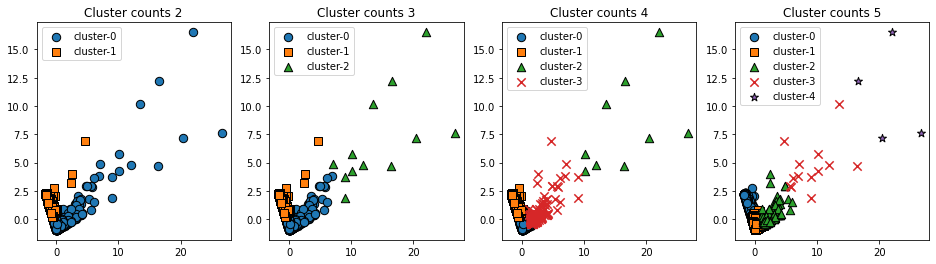

In [71]:
# 군집을 몇개해야 최적화 인가? 잘 분류되었는가?
'''
군집이 2개이면 잘 분류된다
군집이 3개 이상부터는 특정 군집의 크기가 너무 작다 -> 소수의 고객이 대량구매를 했다
이미 왜곡된 데이터에서는 군집을 늘려봤자 동일 결과이다

비지도 학습의 목표 => 숨어있는 새로운 집단을 발견한다
이것을 통해서 데이터를 전혀 다른각도록 볼수 있다(통찰)
'''
visual_silhouette_check( [2,3,4,5], X_features_scaled )
# 데이터 분포도 -> 산포도
visual_cluster_scatter( [2,3,4,5], X_features_scaled )
# 군집 분류는 잘되지만, 소수 군집이 다수로 존재하게 되어 조정이 필요

#### 데이터를 로그 처리 후 군집화

In [72]:
cus_df.head(2)

,CustomerID,Recency,Frequency,Monetary,cluster_label
0,12346,326,1,77183.60,2
1,12747,3,103,4196.01,0


In [73]:
# np.log1p() 를 이용하여 데이터 세트의 왜곡 정도를 낮춘다.
cus_df['Recency_log'] = np.log1p(cus_df['Recency'])
cus_df['Frequency_log'] = np.log1p(cus_df['Frequency'])
cus_df['Monetary_log'] = np.log1p(cus_df['Monetary'])
cus_df.head(2)

,CustomerID,Recency,Frequency,Monetary,cluster_label,Recency_log,Frequency_log,Monetary_log
0,12346,326,1,77183.60,2,5.789960,0.693147,11.253955
1,12747,3,103,4196.01,0,1.386294,4.644391,8.342128


In [74]:
cus_df.iloc[:,-3:].describe()
# 평균 대비 최고값의 차이가 2~4배 미만으로 줄어들었다, 편차가 줄어들었다.

,Recency_log,Frequency_log,Monetary_log
count,3920.000000,3920.000000,3920.000000
mean,3.854807,3.721360,6.546162
std,1.306274,1.260138,1.243661
min,0.693147,0.693147,1.558145
25%,2.944439,2.890372,5.708040
50%,3.951244,3.737670,6.482006
75%,4.969813,4.607658,7.363650
max,5.926926,8.968014,12.467122


In [75]:
# 전처리 수행
X_features = cus_df.iloc[:,-3:].values
X_features_scaled = StandardScaler().fit_transform(X_features)

In [76]:
# KMeans 적용
kmeans = KMeans(n_clusters=3, random_state=0)
cus_df['cluster_label2'] = kmeans.fit_predict(X_features_scaled)
cus_df.head(2)

,CustomerID,Recency,Frequency,Monetary,cluster_label,Recency_log,Frequency_log,Monetary_log,cluster_label2
0,12346,326,1,77183.60,2,5.789960,0.693147,11.253955,2
1,12747,3,103,4196.01,0,1.386294,4.644391,8.342128,1


In [77]:
# 실루엣 계수 평균 
silhouette_score(X_features_scaled, cus_df['cluster_label2'])
# 로그 처리 후 점수는 더 떨어졌다. -> 시각화해서 군집형태는 확인

0.3033967048804945

[0 1]
[0 1 2]
[0 1 2 3]
[0 1 2 3 4]


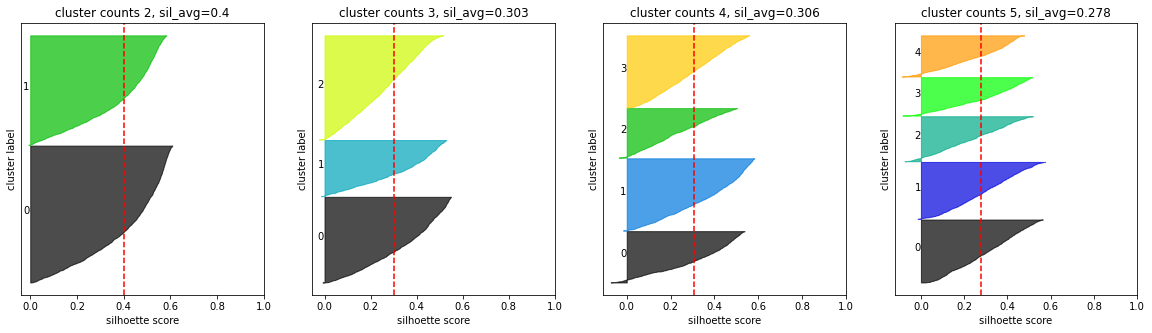

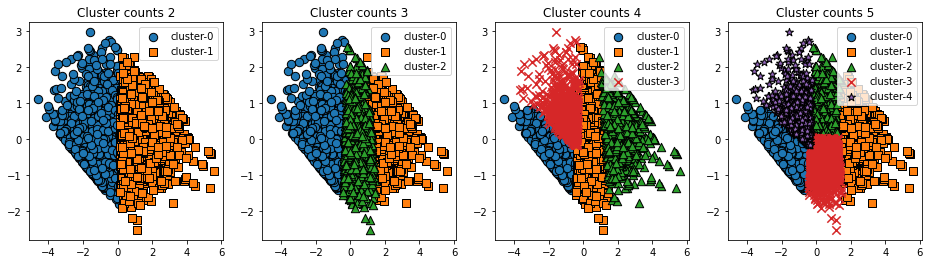

In [78]:
visual_silhouette_check( [2,3,4,5], X_features_scaled )
visual_cluster_scatter( [2,3,4,5], X_features_scaled )
# 실루엣계수는 줄었지만, 시각화를 통해서 군집이 더 잘되 있음을 알수 있다
# 군집의 크기가 거의 일정 -=> 균일성은 증가
# 군진 평가는 실루엣계수, 시각화등을 병행햐여 종합적으로 판단한다!! -> 
# 군집의 성패를 해당 기준으로 군집화하여 서비스/분석을 수행시 성과를 보고 판단!!